# Leveraging a Weighted FTN

FTN (Forecasted Trajectory Neighbors) is an instance-based (good old KNN) approach for improving multi-step forecasts, especially for long horizons.

In the previous notebook (04-ftn_longhorizon), I described how to couple FTN with NHITS. In short-term forecasts, FTN is, in principle, not effective. So, it makes sense to weight it's effect differently along the horizon. Here's how to do that using a validation set.

This notebook explores how to optimize FTN's weights along the horizon

1. Loading LongHorizon's ETTm2 dataset
2. Fitting a NHITS model and predicting on a validation set
3. Fitting FTN and predicting on a validation set
4. Optimize FTN's weights
5. Re-fit NHITS and FTN using all training data
6. Getting forecasts from NHITS and post-processing them using a weighted FTN
7. Evaluating all models

In [23]:
import warnings

warnings.filterwarnings("ignore")

If necessary, install the package using pip:

In [2]:
# !pip install metaforecast -U

### 1. Data preparation

Let's start by loading the dataset.
This tutorial uses the ETTm2 dataset available on datasetsforecast.

We also set the forecasting horizon and input size (number of lags) to 360, 6 hours of data.

In [3]:
import pandas as pd

from datasetsforecast.long_horizon import LongHorizon

# ade is best suited for short-term forecasting
horizon = 360
n_lags = 360

df, *_ = LongHorizon.load('.',group='ETTm2')

df['ds'] = pd.to_datetime(df['ds'])

Setting up a function to split the dataset into training and testing sets:

In [4]:
def train_test_split_df(df: pd.DataFrame):
    df_by_unq = df.groupby('unique_id')

    train_l, test_l = [], []
    for g, df_ in df_by_unq:
        df_ = df_.sort_values('ds')
    
        train_df_g = df_.head(-horizon)
        test_df_g = df_.tail(horizon)
    
        train_l.append(train_df_g)
        test_l.append(test_df_g)
    
    train_df = pd.concat(train_l).reset_index(drop=True)
    test_df = pd.concat(test_l).reset_index(drop=True)

    return train_df, test_df

Prepare training, testing, development, and validation sets

In [5]:
train_df, test_df = train_test_split_df(df)
dev_df, valid_df = train_test_split_df(train_df)

dev_df.query('unique_id=="HUFL"').tail()

,unique_id,ds,y
56875,HUFL,2018-02-13 10:45:00,-1.633847
56876,HUFL,2018-02-13 11:00:00,-1.985959
56877,HUFL,2018-02-13 11:15:00,-1.881931
56878,HUFL,2018-02-13 11:30:00,-1.665849
56879,HUFL,2018-02-13 11:45:00,-1.601846


In [6]:
valid_df.query('unique_id=="HUFL"').head()

,unique_id,ds,y
0,HUFL,2018-02-13 12:00:00,-1.809903
1,HUFL,2018-02-13 12:15:00,-1.721828
2,HUFL,2018-02-13 12:30:00,-1.673873
3,HUFL,2018-02-13 12:45:00,-1.801879
4,HUFL,2018-02-13 13:00:00,-1.713803


### 2. Model setup and fitting

We focus on NHITS, which has been shown to excel on long-horizon forecasting problems.

Default configuration for simplicity

In [7]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from metaforecast.longhorizon import MLForecastFTN as FTN

CONFIG = {
    'max_steps': 1000,
    'input_size': n_lags,
    'h': horizon,
    'enable_checkpointing': True,
    'accelerator': 'cpu'}

models = [NHITS(start_padding_enabled=True, **CONFIG),]

nf = NeuralForecast(models=models, freq='15min')
ftn = FTN(horizon=horizon, n_neighbors=150, apply_ewm=True)

2024-10-10 23:07:35,369	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-10 23:07:35,423	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
INFO:lightning_fabric.utilities.seed:Seed set to 1


### 3. Cross-validation

We first run a validation cycle to estimate FTN's weights

In [8]:
import numpy as np

# auxiliary function to get horizon info
def get_horizon(cv: pd.DataFrame):
    if 'horizon' in cv.columns:
        raise ValueError('"horizon" column already in the dataset.')

    if 'cutoff' in cv.columns:
        cv_g = cv.groupby(['unique_id', 'cutoff'])
    else:
        cv_g = cv.groupby(['unique_id'])

    horizon = []
    for g, df in cv_g:
        df = df.sort_values('ds')
        h = np.asarray(range(1, df.shape[0] + 1))
        hs = {
            'horizon': h,
            'ds': df['ds'].values,
            'unique_id': df['unique_id'].values,
        }
        if 'cutoff' in df.columns:
            hs['cutoff'] = df['cutoff'].values,

        hs = pd.DataFrame(hs)
        horizon.append(hs)

    horizon = pd.concat(horizon)

    if 'cutoff' in cv.columns:
        cv = cv.merge(horizon, on=['unique_id', 'ds', 'cutoff'])
    else:
        cv = cv.merge(horizon, on=['unique_id', 'ds'])

    return cv

In [9]:
%%capture

nf.fit(df=dev_df)
ftn.fit(dev_df)

fcst_dev_nf = nf.predict()
fcst_dev_ftn = ftn.predict(fcst_dev_nf)

valid_df = valid_df.merge(fcst_dev_ftn, on=['unique_id', 'ds'], how="left")
valid_df = get_horizon(valid_df)

weights = ftn.alpha_cv_scoring(valid_df)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.6 M  | train
-------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.445    Total estimated model params size (MB)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zer

Here are the estimated weights along the horizon. For short-term predictions, FTN is mostly ineffective

<Axes: >

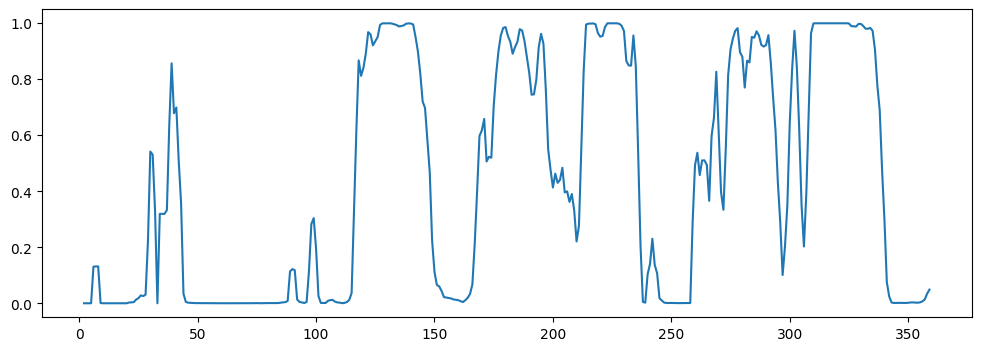

In [10]:
pd.Series(weights['NHITS']).rolling(3).mean().plot(figsize=(12,4))

In [11]:
ftn.apply_weighting = True
ftn.set_alpha_weights(weights)

### 4. Re-fitting models

Now, we re-fit both models on the complete training data.

In [12]:
%%capture

nf.fit(df=train_df)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.6 M  | train
-------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.445    Total estimated model params size (MB)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


In [13]:
ftn.fit(train_df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.87it/s]


In [14]:
fcst_nf = nf.predict()

fcst_ftn = ftn.predict(fcst_nf)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 110.51it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 46.07it/s]


In [15]:
fcst_ftn.head()

,ds,NHITS,NHITS(WFTN)
unique_id,,,
HUFL,2018-02-17 06:00:00,-2.142243,-2.142243
HUFL,2018-02-17 06:15:00,-2.135545,-2.135545
HUFL,2018-02-17 06:30:00,-2.128394,-2.128394
HUFL,2018-02-17 06:45:00,-2.119522,-2.119522
HUFL,2018-02-17 07:00:00,-2.100488,-2.100487


Below are the weights of each model (equal across all unique ids because weight_by_uid=False)

Then, we refit the neural networks are get the test forecasts

### 4. Evaluation

Finally, we compare all approaches

In [16]:
test_df = test_df.merge(fcst_ftn, on=['unique_id','ds'], how="left")

In [17]:
from neuralforecast.losses.numpy import smape
from datasetsforecast.evaluation import accuracy

evaluation_df = accuracy(test_df, [smape], agg_by=['unique_id'])

In [18]:
eval_df = evaluation_df.drop(columns=['metric','unique_id'])

eval_df

,NHITS,NHITS(WFTN)
0,0.162648,0.163075
1,0.253831,0.258548
2,0.046690,0.042557
3,0.570899,0.494612
4,0.194261,0.209592
5,0.323341,0.390476
6,0.217687,0.214806


In [21]:
eval_df.mean().sort_values()

NHITS          0.252765
NHITS(WFTN)    0.253381
dtype: float64

In [22]:
eval_df.median().sort_values()

NHITS(WFTN)    0.214806
NHITS          0.217687
dtype: float64